In [1]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Operasi Morfologi

In [ ]:
#GM-1
def morph_opening_closing(img, kernel):
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    return closing

In [ ]:
#GM-2
def morph_closing_opening(img, kernel):
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
    return opening

In [ ]:
#GM-3
def morph_opening_dilation(img, kernel):
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    dilation = cv2.dilate(opening, kernel, iterations=1)
    return dilation

In [ ]:
#GM-4
def morph_opening_erosion(img, kernel):
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    erosion = cv2.erode(opening, kernel, iterations=1)
    return erosion

In [ ]:
#GM-5
def morph_closing_dilation(img, kernel):
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    dilation = cv2.dilate(closing, kernel, iterations=1)
    return dilation

In [ ]:
#GM-6
def morph_closing_erosion(img, kernel):
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    erosion = cv2.erode(closing, kernel, iterations=1)
    return erosion

In [ ]:
# Proses data citra
def preprocess_images(input_folder, output_folder, morph_function):
    # Membuat folder output jika tidak ada
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Mendapatkan daftar file dalam folder input
    file_list = os.listdir(input_folder)
    kernel = np.ones((5, 5), np.uint8)

    for file_name in file_list:
        # Membaca setiap gambar
        img_path = os.path.join(input_folder, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            continue

        # Menerapkan fungsi morfologi yang dipilih
        processed_img = morph_function(img, kernel)

        # Menyimpan hasil ke folder output
        output_path = os.path.join(output_folder, file_name)
        cv2.imwrite(output_path, processed_img)

In [ ]:
# Penggunaan folder (manual)
input_folder = '/content/gdrive/MyDrive/Dataset/sea-clutters/HB'
output_folder = '/content/gdrive/MyDrive/Dataset/sea-clutters/GHB6'
morph_function = morph_closing_erosion # Ganti dengan fungsi morfologi yang diinginkan

preprocess_images(input_folder, output_folder, morph_function)

# Harmonic mean filter

In [ ]:
def harmonic_mean_filter(image, kernel_size=3):
    # Menyiapkan kernel
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32)
    kernel = kernel / np.sum(kernel)

    # Menentukan padding berdasarkan ukuran kernel
    pad_size = kernel_size // 2
    padded_image = cv2.copyMakeBorder(image, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_REPLICATE)

    # Menyiapkan citra hasil
    filtered_image = np.zeros_like(image, dtype=np.float32)

    # Iterasi melalui citra dengan kernel
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Ekstrak wilayah yang sesuai dengan kernel
            region = padded_image[i:i+kernel_size, j:j+kernel_size]

            # Menghindari pembagian dengan nol
            region[region == 0] = 1e-10

            # Menghitung harmonic mean
            harmonic_mean = kernel_size * kernel_size / np.sum(1.0 / region)

            # Menyimpan hasil ke citra keluaran
            filtered_image[i, j] = harmonic_mean

    return np.clip(filtered_image, 0, 255).astype(np.uint8)

In [ ]:
def process_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_filtered = harmonic_mean_filter(img)
            output_path = os.path.join(output_folder, file_name)
            cv2.imwrite(output_path, img_filtered)
            print(f"Gambar hasil disimpan di: {output_path}")

# Penggunaan fungsi
input_folder = '/content/gdrive/MyDrive/Dataset/sea-clutters/images'
output_folder = '/content/gdrive/MyDrive/Dataset/sea-clutters/harmonic'
process_images(input_folder, output_folder)
print('Proses harmonic mean filtering telah selesai.')

# Bandpass Filter

In [ ]:
def bandpass_filter(image, min_freq, max_freq):
    # Konversi citra ke domain frekuensi
    discrete_fourier_transform = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    # Pusatkan komponen frekuensi rendah
    frequency_shift = np.fft.fftshift(discrete_fourier_transform)

    # Inisialisasi ukuran citra
    rows, cols = image.shape
    center_row, center_col = rows // 2, cols // 2

    # Membuat mask untuk low-pass filter
    low_pass_mask = np.zeros((rows, cols, 2), np.uint8)
    cv2.circle(low_pass_mask, (center_col, center_row), max_freq, (1, 1), -1)

    # Membuat mask untuk high-pass filter
    high_pass_mask = np.ones((rows, cols, 2), np.uint8)
    cv2.circle(high_pass_mask, (center_col, center_row), min_freq, (0, 0), -1)

    # Gabungkan kedua mask untuk membentuk bandpass filter
    bandpass_mask = low_pass_mask * high_pass_mask

    # Terapkan bandpass filter dan lakukan inverse DFT
    filtered_frequency = frequency_shift * bandpass_mask
    inverse_frequency_shift = np.fft.ifftshift(filtered_frequency)
    image_result = cv2.idft(inverse_frequency_shift)
    image_result = cv2.magnitude(image_result[:, :, 0], image_result[:, :, 1])

    # Normalisasi kembali ke skala grayscale
    normalized_image = np.uint8(np.clip((image_result / np.max(image_result)) * 255, 0, 255))

    return normalized_image

def process_image_folder(source_folder, destination_folder, frequency_lower_bound, frequency_upper_bound):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    for file_name in os.listdir(source_folder):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_file_path = os.path.join(source_folder, file_name)
            grayscale_image = cv2.imread(img_file_path, 0)  # Membaca gambar sebagai grayscale

            # Terapkan bandpass filter
            processed_image = apply_bandpass_filter(grayscale_image, frequency_lower_bound, frequency_upper_bound)

            # Simpan hasil gambar yang telah difilter
            saved_image_path = os.path.join(destination_folder, file_name)
            cv2.imwrite(saved_image_path, processed_image)
            print(f'Processed image: {file_name}')

# Path untuk folder input dan output
source_folder = '/path/to/input/folder'  # Ubah sesuai dengan lokasi folder input Anda
destination_folder = '/path/to/output/folder'  # Ubah sesuai dengan lokasi folder output Anda

# Batas frekuensi untuk bandpass filter
frequency_lower_bound = 5
frequency_upper_bound = 150

# Mulai proses gambar di folder input
process_image_folder(source_folder, destination_folder, frequency_lower_bound, frequency_upper_bound)

print('Image filtering process completed')

#Image Quality Metrics

In [ ]:
import os

# Mendefinisikan direktori yang ingin dicek jumlah file-nya
folder_path = '/content/gdrive/MyDrive/Dataset/sea-clutters/GHB6'

# Menghitung jumlah file dalam folder
file_count = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])

print(f"Jumlah file dalam folder '{folder_path}' adalah {file_count}.")

Jumlah file dalam folder '/content/gdrive/MyDrive/Dataset/sea-clutters/GHB6' adalah 924.


In [ ]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import os

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=img2.max() - img1.min())

def process_images(dataset_folder):
    psnr_vals, mse_vals, ssim_vals = [], [], []
    filenames = os.listdir(dataset_folder)

    for filename in filenames:
        original_path = os.path.join(dataset_folder, "/content/gdrive/MyDrive/Dataset/sea-clutters/GHB6", filename)
        denoised_path = os.path.join(dataset_folder, "/content/gdrive/MyDrive/Dataset/sea-clutters/images", filename)

        original_img = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
        denoised_img = cv2.imread(denoised_path, cv2.IMREAD_GRAYSCALE)

        if original_img is not None and denoised_img is not None:
            psnr_vals.append(calculate_psnr(original_img, denoised_img))
            mse_vals.append(np.mean((original_img - denoised_img) ** 2))
            ssim_vals.append(calculate_ssim(original_img, denoised_img))

    return psnr_vals, mse_vals, ssim_vals

# Path ke folder dataset
dataset_folder = '/content/gdrive/MyDrive/Dataset/sea-clutters/images'

# Mengolah citra dan menghitung metrik
psnr_vals, mse_vals, ssim_vals = process_images(dataset_folder)

# Output statistik
print(f"Mean PSNR: {np.mean(psnr_vals)}, Mean MSE: {np.mean(mse_vals)}, Mean SSIM: {np.mean(ssim_vals)}")

Mean PSNR: 28.81745076206863, Mean MSE: 86.36780985693994, Mean SSIM: 0.2244563650934676


# Menampilkan satu gambar before dan aftrer

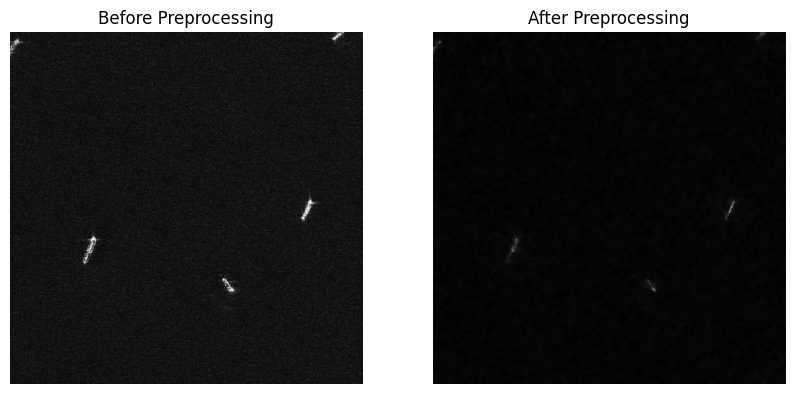

In [2]:
import cv2
from matplotlib import pyplot as plt

def display_before_after(original_image_path, processed_image_path):
    # Muat gambar asli dan hasil olah
    original_image = cv2.imread(original_image_path, 0)  # 0 untuk grayscale
    processed_image = cv2.imread(processed_image_path, 0)

    # Konversi dari BGR ke RGB untuk matplotlib
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)

    # Menyiapkan plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Before Preprocessing')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed_image, cmap='gray')
    plt.title('After Preprocessing')
    plt.axis('off')

    plt.show()

# Jalankan fungsi display dengan path ke gambar asli dan hasil olah
original_image_path = '/content/gdrive/MyDrive/Dataset/sea-clutters/images/P0020_5160_5960_6000_6800.jpg'
processed_image_path = '/content/gdrive/MyDrive/Dataset/sea-clutters/GHB6/P0020_5160_5960_6000_6800.jpg'
display_before_after(original_image_path, processed_image_path)

# Analisis Filter

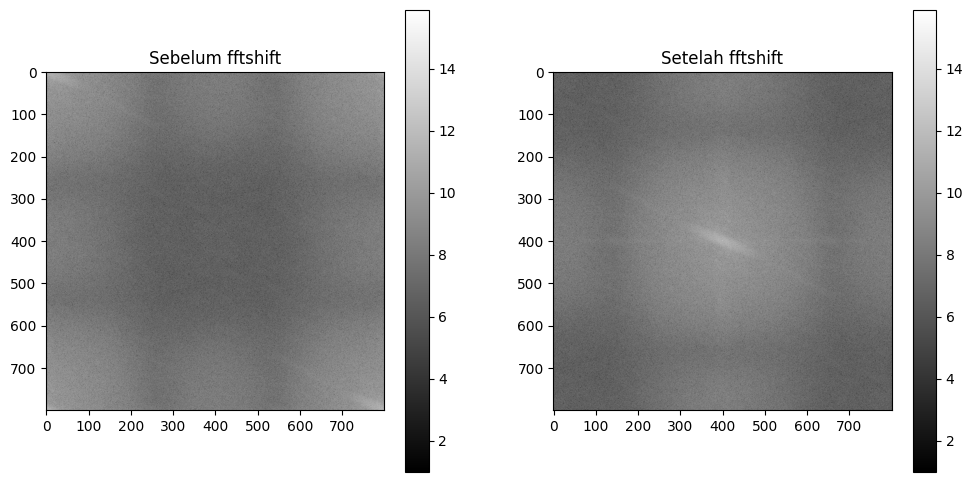

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Membaca citra sebagai grayscale
path = '/content/gdrive/MyDrive/Dataset/sea-clutters/harmonic/P0020_5160_5960_6600_7400.jpg'
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# Periksa apakah citra terbaca dengan benar
if image is None:
    print("Citra tidak dapat dibaca. Periksa apakah path benar dan file dapat diakses.")
else:
    # Menerapkan FFT
    f = np.fft.fft2(image)
    f_shifted = np.fft.fftshift(f)

    # Menghitung magnitude dari FFT
    magnitude = np.abs(f)
    magnitude_shifted = np.abs(f_shifted)

    # Visualisasi
    plt.figure(figsize=(12, 6))
    plt.subplot(121), plt.imshow(np.log(magnitude + 1), cmap='gray'), plt.title('Sebelum fftshift')
    plt.colorbar()
    plt.subplot(122), plt.imshow(np.log(magnitude_shifted + 1), cmap='gray'), plt.title('Setelah fftshift')
    plt.colorbar()
    plt.show()

In [ ]:
import cv2
import numpy as np

# Fungsi untuk menampilkan sebagian kecil gambar sebagai kernel
def extract_kernel_from_image(image, center_x, center_y, kernel_size):
    half_size = kernel_size // 2
    kernel = image[center_y - half_size:center_y + half_size + 1, center_x - half_size:center_x + half_size + 1]
    return kernel

# Baca gambar
image = cv2.imread('/content/gdrive/MyDrive/Dataset/sea-clutters/images anot/P0019_1800_2600_0_800.jpg')
image = cv2.resize(image, (800, 800))  # Pastikan ukuran gambar 800x800

# Konversi gambar ke skala abu-abu jika perlu
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Tentukan posisi tengah gambar
center_x, center_y = 800 // 2, 800 // 2

# Ambil kernel 3x3 dari pusat gambar
kernel_3x3 = extract_kernel_from_image(gray_image, center_x, center_y, 3)

# Ambil kernel 5x5 dari pusat gambar
kernel_5x5 = extract_kernel_from_image(gray_image, center_x, center_y, 5)

# Cetak nilai-nilai kernel
print("Kernel 3x3 dari pusat gambar:")
print(kernel_3x3)

print("\nKernel 5x5 dari pusat gambar:")
print(kernel_5x5)

Kernel 3x3 dari pusat gambar:
[[58 24 29]
 [47 36 20]
 [22 29 19]]

Kernel 5x5 dari pusat gambar:
[[32 43 62 45 24]
 [44 58 24 29 46]
 [26 47 36 20 27]
 [ 4 22 29 19 25]
 [49 30 26 23 24]]
